# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [104]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [108]:
import zipfile
import os

# Path to your ZIP file
zip_path = 'RNN_Stock_Starter_Dataset.zip'
extract_path = 'stock_data'

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

Extracted files: ['RNN_Stock_Starter_Dataset']


In [29]:
# Check for missing values

print(amzn.isnull().sum())
print(googl.isnull().sum())
print(ibm.isnull().sum())
print(msft.isnull().sum())



Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [30]:
# Confirm shape

print(amzn.shape)  # Should be (3019, 7)
print(googl.shape)  # Should be (3019, 7)
print(ibm.shape)  # Should be (3019, 7)
print(msft.shape)  # Should be (3019, 7)

(3019, 7)
(3019, 7)
(3020, 7)
(3019, 7)


In [31]:
#Convert Date Column to Datetime Format

for df in [amzn, googl, ibm, msft]:
    df['Date'] = pd.to_datetime(df['Date'])

#Sort by Date (if not already sorted)


for df in [amzn, googl, ibm, msft]:
    df.sort_values('Date', inplace=True)

#Set Date as Index (optional but useful for time series work)


for df in [amzn, googl, ibm, msft]:
    df.set_index('Date', inplace=True)



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [109]:
# Define a function to load data and aggregate them

def load_and_aggregate_stock_data(file_list):
    combined_df_list = []

    for file_path in file_list:
        stock_name = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path)
        df['Stock'] = stock_name
        if 'Name' in df.columns:
            df.drop(columns=['Name'], inplace=True)
        combined_df_list.append(df)
    combined_df = pd.concat(combined_df_list, ignore_index=True)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df = combined_df.sort_values(by=['Date', 'Stock']).reset_index(drop=True)

    return combined_df

In [110]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

data_folder = 'stock_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data'
stock_files = [
    os.path.join(data_folder, 'AMZN_stocks_data.csv'),
    os.path.join(data_folder, 'GOOGL_stocks_data.csv'),
    os.path.join(data_folder, 'IBM_stocks_data.csv'),
    os.path.join(data_folder, 'MSFT_stocks_data.csv')
]

# Step 3: Use the aggregation function to load and merge the data
stock_data = load_and_aggregate_stock_data(stock_files)

In [111]:
# View specifics of the data

# View specifics of the data

stock_data.head()

,Date,Open,High,Low,Close,Volume,Stock
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN_stocks_data
1,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL_stocks_data
2,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM_stocks_data
3,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT_stocks_data
4,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN_stocks_data


In [112]:
print("Shape of data:", stock_data.shape)

Shape of data: (12077, 7)


In [113]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12077 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12077 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12077 non-null  float64       
 5   Volume  12077 non-null  int64         
 6   Stock   12077 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 660.6+ KB


In [114]:
print("Missing values per column:\n")
print(stock_data.isnull().sum())

Missing values per column:

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Stock     0
dtype: int64


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [36]:
# Handle Missing Values

# Check missing values
print("Missing values in each column:")
print(stock_data.isnull().sum())

Missing values in each column:
Date     0
AMZN     0
GOOGL    0
IBM      0
MSFT     0
dtype: int64


In [37]:
# Handle missing values using forward fill, then back fill (for any remaining NaNs at the top)
stock_data.fillna(method='ffill', inplace=True)
stock_data.fillna(method='bfill', inplace=True)

# Re-check if all missing values are handled
print("\nAfter filling, missing values in each column:")
print(stock_data.isnull().sum())


After filling, missing values in each column:
Date     0
AMZN     0
GOOGL    0
IBM      0
MSFT     0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [39]:
# Frequency distribution of volumes

def load_stock_volume_data(file_paths):
    """
    Load stock data with Volume column for analysis.

    Parameters:
    - file_paths (dict): Dictionary of {stock_name: file_path}

    Returns:
    - dict: Dictionary of {stock_name: DataFrame with Date and Volume}
    """
    volume_data = {}
    for name, path in file_paths.items():
        df = pd.read_csv(path)
        df = df[['Date', 'Volume']].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        volume_data[name] = df
    return volume_data


volume_data = load_stock_volume_data(file_paths)

volume_data

{'AMZN':            Date   Volume
 0    2006-01-03  7582127
 1    2006-01-04  7440914
 2    2006-01-05  5417258
 3    2006-01-06  6154285
 4    2006-01-09  8945056
 ...         ...      ...
 3014 2017-12-22  1585054
 3015 2017-12-26  2005187
 3016 2017-12-27  1867208
 3017 2017-12-28  1841676
 3018 2017-12-29  2688391
 
 [3019 rows x 2 columns],
 'GOOGL':            Date    Volume
 0    2006-01-03  13137450
 1    2006-01-04  15292353
 2    2006-01-05  10815661
 3    2006-01-06  17759521
 4    2006-01-09  12795837
 ...         ...       ...
 3014 2017-12-22    889446
 3015 2017-12-26    918767
 3016 2017-12-27   1116203
 3017 2017-12-28    994249
 3018 2017-12-29   1180340
 
 [3019 rows x 2 columns],
 'IBM':            Date    Volume
 0    2006-01-03  11715200
 1    2006-01-04   9840600
 2    2006-01-05   7213500
 3    2006-01-06   8197400
 4    2006-01-09   6858200
 ...         ...       ...
 3015 2017-12-22   2990583
 3016 2017-12-26   2479017
 3017 2017-12-27   2149257
 3018 2017-12-

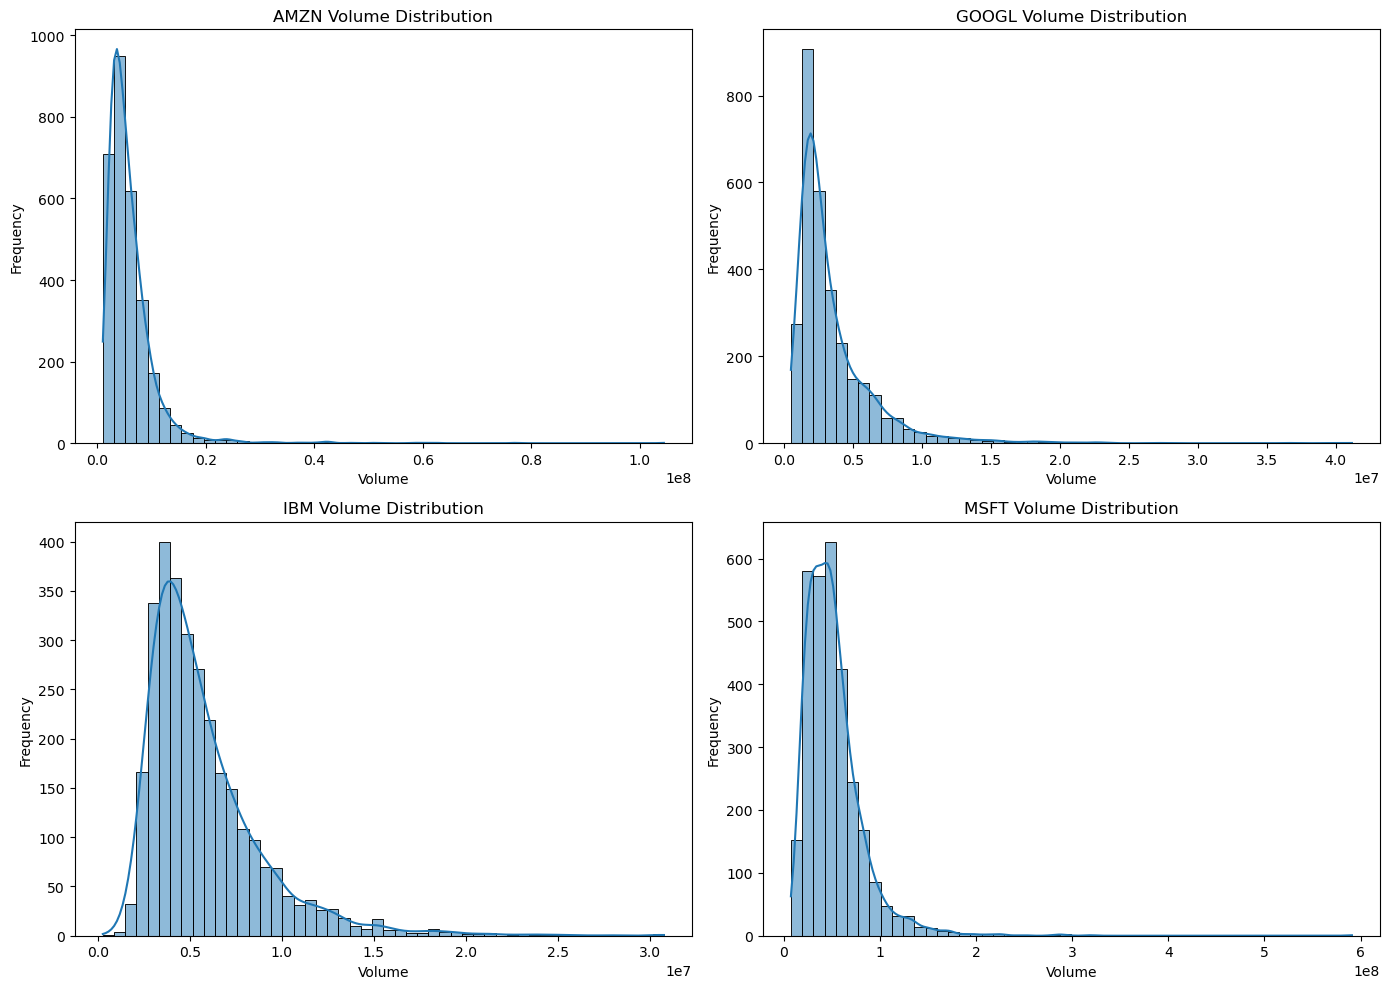

In [40]:
# Plot histograms of volumes

plt.figure(figsize=(14, 10))
for i, (stock, df) in enumerate(volume_data.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df['Volume'], kde=True, bins=50)
    plt.title(f'{stock} Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

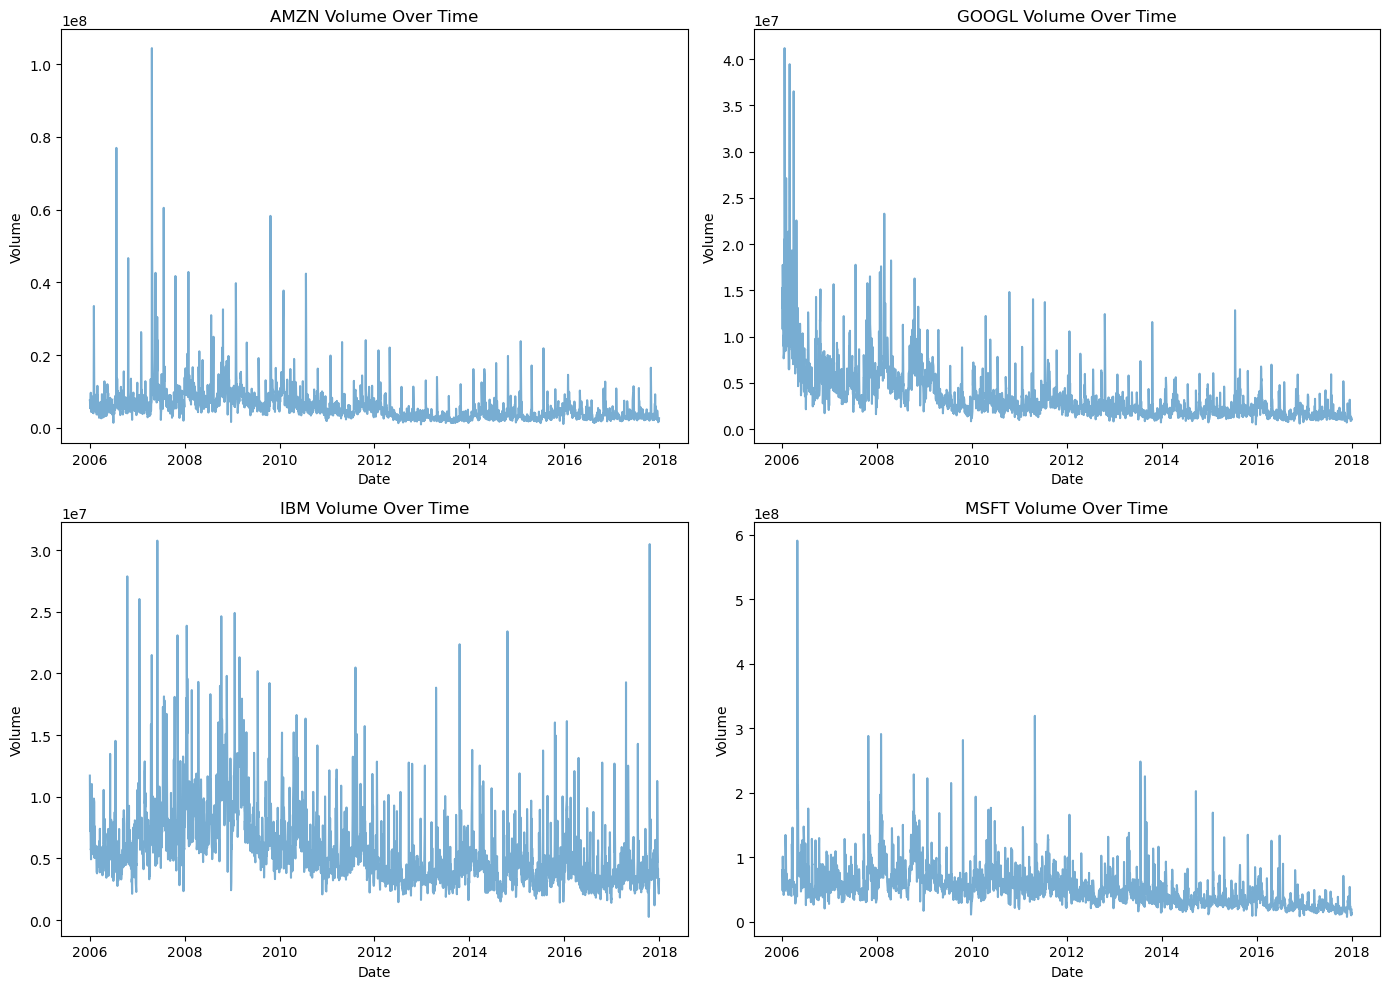

In [41]:
# Stock volume variation over time

# Plot time series of volumes

plt.figure(figsize=(14, 10))
for i, (stock, df) in enumerate(volume_data.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(df['Date'], df['Volume'], alpha=0.6)
    plt.title(f'{stock} Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')

plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [42]:
# Analyse correlations

def load_full_stock_data(file_paths):
    """
    Load full stock data with Open, High, Low, Close, Volume for correlation analysis.

    Parameters:
    - file_paths (dict): {stock_name: file_path}

    Returns:
    - dict: {stock_name: DataFrame}
    """
    stock_full_data = {}
    for name, path in file_paths.items():
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        stock_full_data[name] = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return stock_full_data


full_stock_data = load_full_stock_data(file_paths)

full_stock_data

{'AMZN':            Date     Open     High      Low    Close   Volume
 0    2006-01-03    47.47    47.85    46.25    47.58  7582127
 1    2006-01-04    47.48    47.73    46.69    47.25  7440914
 2    2006-01-05    47.16    48.20    47.11    47.65  5417258
 3    2006-01-06    47.97    48.58    47.32    47.87  6154285
 4    2006-01-09    46.55    47.10    46.40    47.08  8945056
 ...         ...      ...      ...      ...      ...      ...
 3014 2017-12-22  1172.08  1174.62  1167.83  1168.36  1585054
 3015 2017-12-26  1168.36  1178.32  1160.55  1176.76  2005187
 3016 2017-12-27  1179.91  1187.29  1175.61  1182.26  1867208
 3017 2017-12-28  1189.00  1190.10  1184.38  1186.10  1841676
 3018 2017-12-29  1182.35  1184.00  1167.50  1169.47  2688391
 
 [3019 rows x 6 columns],
 'GOOGL':            Date     Open     High      Low    Close    Volume
 0    2006-01-03   211.47   218.05   209.32   217.83  13137450
 1    2006-01-04   222.17   224.70   220.09   222.84  15292353
 2    2006-01-05   223

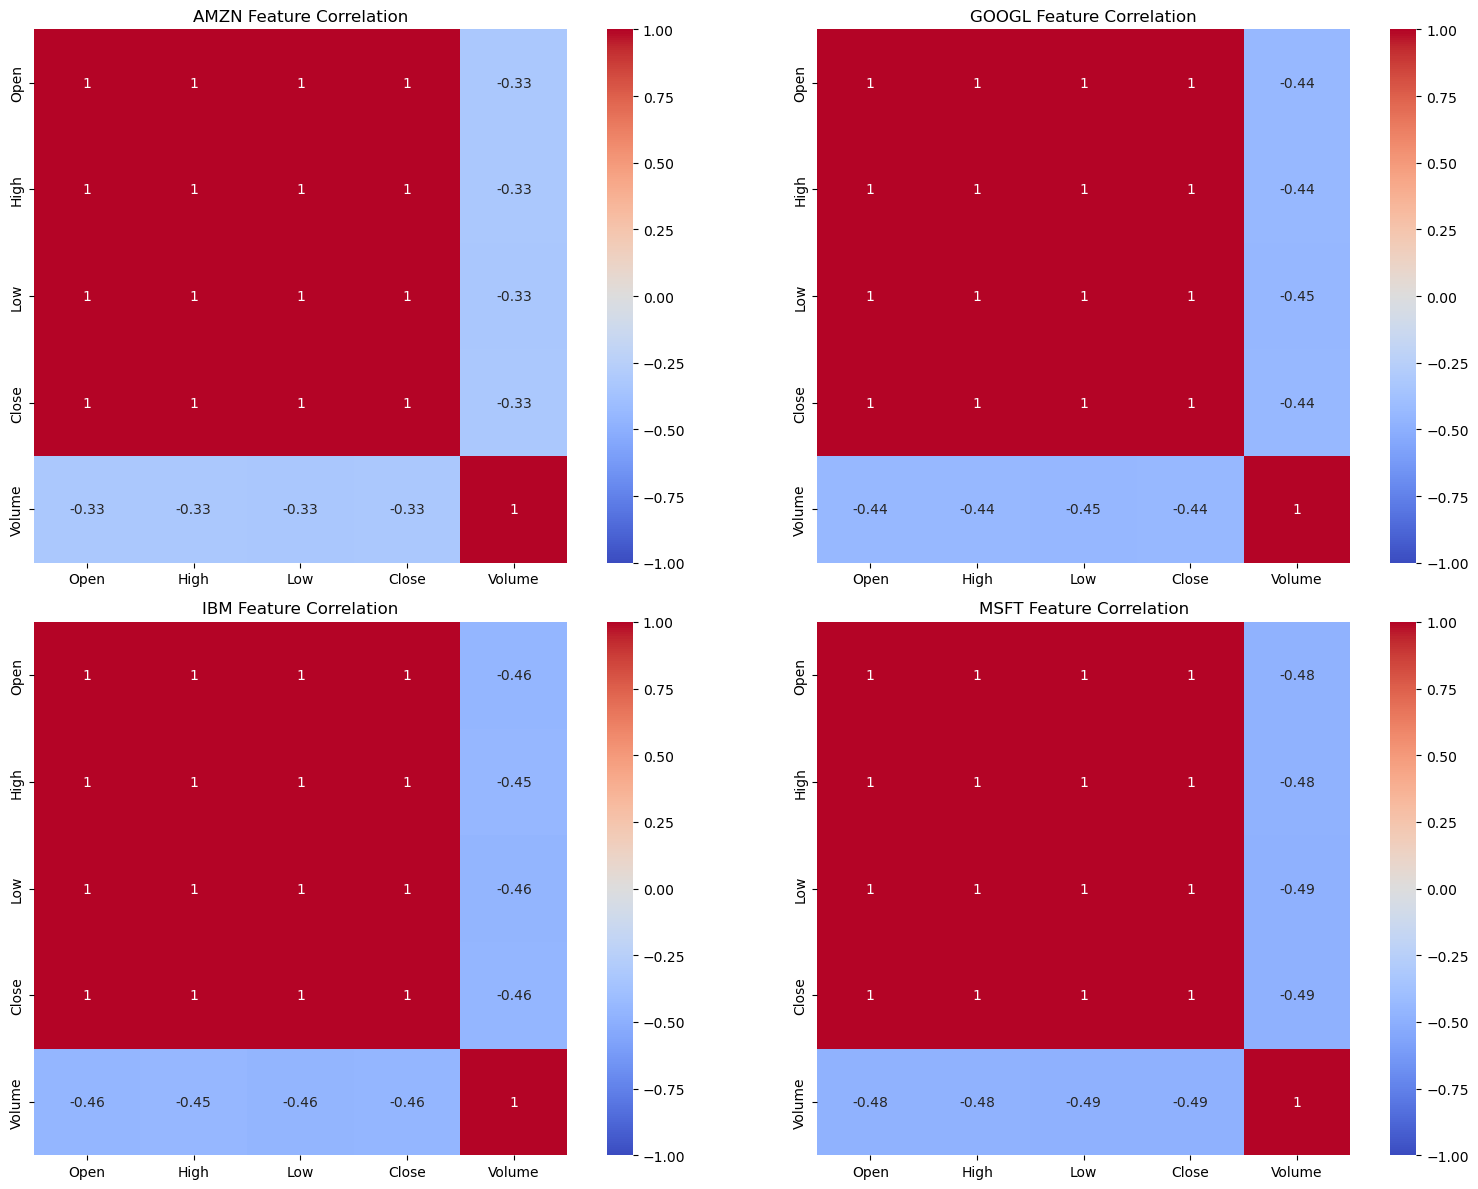

In [43]:
# Plot correlation heatmaps

plt.figure(figsize=(16, 12))
for i, (stock, df) in enumerate(full_stock_data.items(), 1):
    plt.subplot(2, 2, i)
    corr = df.drop(columns='Date').corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title(f'{stock} Feature Correlation')

plt.tight_layout()
plt.show()

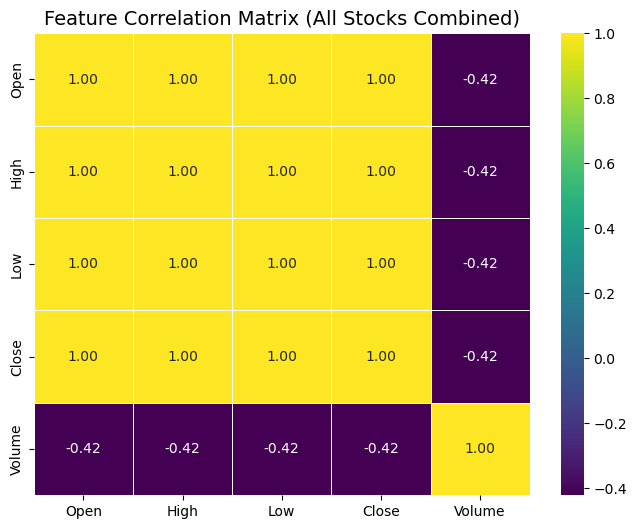

In [116]:
# Analyse correlations
correlation_df = stock_data.drop(columns=['Date', 'Stock'])

# Compute Pearson correlation matrix
corr_matrix = correlation_df.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)
plt.title('Feature Correlation Matrix (All Stocks Combined)', fontsize=14)
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [45]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_time_windows(data, window_size=60, stride=1, target_shift=1):
    """
    Generate input sequences and target outputs from time series data.

    Parameters:
    - data (ndarray): Shape (n_samples, n_features)
    - window_size (int): Length of each input sequence
    - stride (int): Step size to move the window
    - target_shift (int): Number of steps ahead to predict

    Returns:
    - X (ndarray): Input windows, shape (n_windows, window_size, n_features)
    - y (ndarray): Target values, shape (n_windows, n_features)
    """
    X, y = [], []
    for i in range(0, len(data) - window_size - target_shift + 1, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size + target_shift - 1])  # predict next step
    return np.array(X), np.array(y)


# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(stock_data.drop(columns=['Date']))
data_scaled

# Create windows
window_size = 65
stride = 5
X, y = create_time_windows(data_scaled, window_size=window_size, stride=stride)

print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Input shape: (591, 65, 4), Target shape: (591, 4)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [46]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    """
    Scales the windowed data using MinMaxScaler.

    Parameters:
    - X (ndarray): Input windows, shape (n_windows, window_size, n_features)
    - y (ndarray): Target values, shape (n_windows, n_features)

    Returns:
    - X_scaled (ndarray): Scaled input windows, same shape as X
    - y_scaled (ndarray): Scaled target values, same shape as y
    - scaler (MinMaxScaler): Fitted scaler object for inverse transformation
    """
    # Flatten X to fit the scaler across all time steps and features
    n_windows, window_size, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    y_scaled = scaler.transform(y)

    # Reshape back to original shape
    X_scaled = X_scaled.reshape(n_windows, window_size, n_features)

    return X_scaled, y_scaled, scaler


X_scaled, y_scaled, scaler = scale_windowed_data(X, y)

print("Scaled X shape:", X_scaled.shape)
print("Scaled y shape:", y_scaled.shape)

Scaled X shape: (591, 65, 4)
Scaled y shape: (591, 4)


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [65]:
# Define a function to create input and output data points from the master DataFrame

def generate_input_output_from_df(df, 
                                  target_names=None, 
                                  window_size=60, 
                                  stride=1, 
                                  target_shift=1, 
                                  scale=True):
    """
    Create time-windowed input and output data from a DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time series features.
    - target_names (list): List of feature names to predict. If None, use all.
    - window_size (int): Size of each input window.
    - stride (int): Number of steps to slide the window.
    - target_shift (int): Steps ahead to predict.
    - scale (bool): Whether to apply MinMax scaling.

    Returns:
    - X (ndarray): Input windows of shape (n_samples, window_size, n_features)
    - y (ndarray): Target values of shape (n_samples, n_targets)
    - scaler (MinMaxScaler or None): Fitted scaler for inverse transform
    - feature_names (list): List of features used
    """

    df = df.copy()
    if 'Date' in df.columns:
        df.drop(columns=['Date'], inplace=True)

    feature_names = df.columns.tolist()
    data = df.values

    # Optional scaling
    scaler = None
    if scale:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)

    # Create windows
    X, y = [], []
    target_idx = [df.columns.get_loc(col) for col in (target_names or df.columns)]
    for i in range(0, len(data) - window_size - target_shift + 1, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size + target_shift - 1][target_idx])

    return np.array(X), np.array(y), scaler, feature_names



In [48]:
X, y, scaler, features = generate_input_output_from_df(
    stock_data,
    target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'],
    window_size=65,
    stride=5,
    target_shift=1,
    scale=True
)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (591, 65, 4), y shape: (591, 4)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [49]:
# Checking for patterns in different sequence lengths

window_sizes = [30, 60, 90]
sequence_samples = {}

for w in window_sizes:
    X, y, _, _ = generate_input_output_from_df(
        stock_data,
        target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'],
        window_size=w,
        stride=5,
        target_shift=1,
        scale=True
    )
    print(f"Window Size: {w} -> X shape: {X.shape}, y shape: {y.shape}")
    sequence_samples[w] = X[0]  # Store first sequence for visual inspection

Window Size: 30 -> X shape: (598, 30, 4), y shape: (598, 4)
Window Size: 60 -> X shape: (592, 60, 4), y shape: (592, 4)
Window Size: 90 -> X shape: (586, 90, 4), y shape: (586, 4)


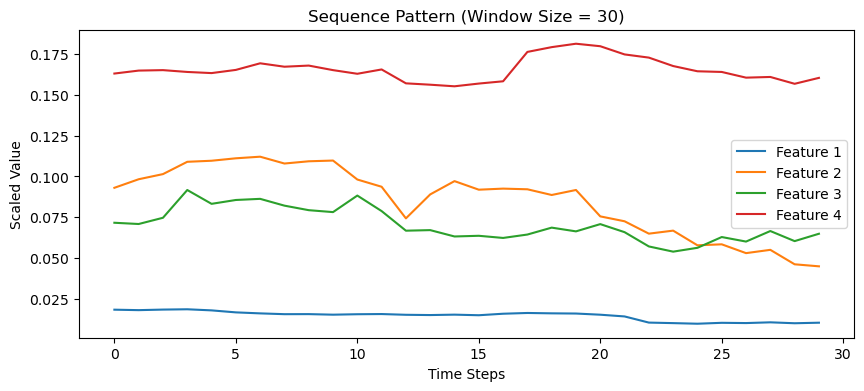

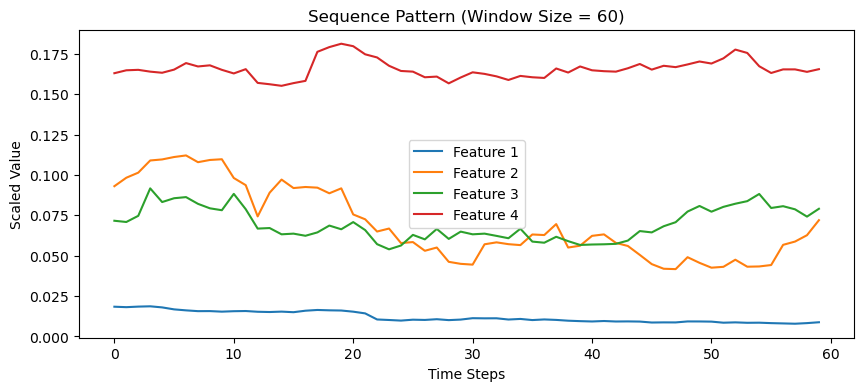

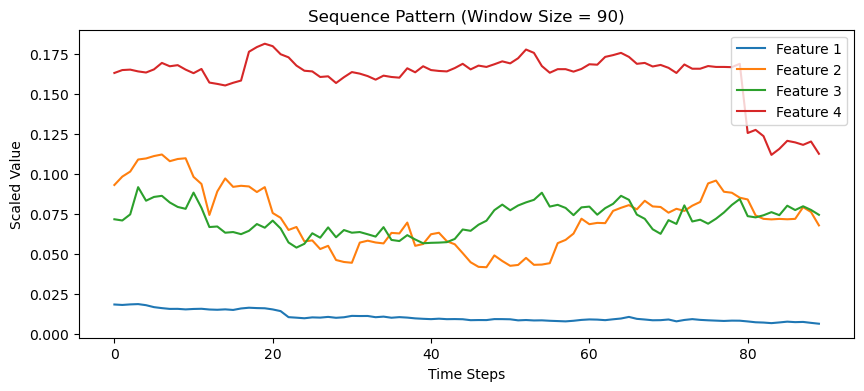

In [50]:
for w, seq in sequence_samples.items():
    plt.figure(figsize=(10, 4))
    for i in range(seq.shape[1]):  # for each stock
        plt.plot(seq[:, i], label=f'Feature {i+1}')
    plt.title(f'Sequence Pattern (Window Size = {w})')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [51]:
# Create data instances from the master data frame using decided window size and window stride

# Define parameters
window_size = 65
stride = 5
target_shift = 1
target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Create data instances
X, y, scaler, feature_names = generate_input_output_from_df(
    stock_data,
    target_names=target_names,
    window_size=window_size,
    stride=stride,
    target_shift=target_shift,
    scale=True
)

# Check result
print(f"X shape: {X.shape}")  # Expected: (n_samples, 65, 4)
print(f"y shape: {y.shape}")  # Expected: (n_samples, 4)

X shape: (591, 65, 4)
y shape: (591, 4)


In [52]:
# Check the number of data points generated

print(f"Number of input sequences (X): {X.shape[0]}")
print(f"Each input sequence shape: {X.shape[1:]}")  # (window_size, num_features)

print(f"Number of output targets (y): {y.shape[0]}")
print(f"Each target shape: {y.shape[1:]}")  # (num_targets,)

Number of input sequences (X): 591
Each input sequence shape: (65, 4)
Number of output targets (y): 591
Each target shape: (4,)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [53]:
# Check if the datasets are compatible inputs to neural networks

print(f"X shape: {X.shape}")  # should be (n_samples, window_size, n_features)
print(f"y shape: {y.shape}")  # should be (n_samples, n_targets)
X = X.astype('float32')
y = y.astype('float32')

print(f"X dtype: {X.dtype}, y dtype: {y.dtype}")

print("Any NaNs in X?", np.isnan(X).any())
print("Any NaNs in y?", np.isnan(y).any())

print("Any Infs in X?", np.isinf(X).any())
print("Any Infs in y?", np.isinf(y).any())



X shape: (591, 65, 4)
y shape: (591, 4)
X dtype: float32, y dtype: float32
Any NaNs in X? False
Any NaNs in y? False
Any Infs in X? False
Any Infs in y? False


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [55]:
# Create a function that creates a simple RNN model according to the model configuration arguments



def create_rnn_model(input_shape, 
                     rnn_units=64, 
                     dense_units=32,
                     output_units=4,
                     rnn_activation='tanh',
                     dense_activation='relu',
                     dropout_rate=0.2,
                     learning_rate=0.001):
    """
    Creates a simple RNN model using Keras.

    Parameters:
    - input_shape (tuple): Shape of input data (timesteps, features)
    - rnn_units (int): Number of units in the RNN layer
    - dense_units (int): Number of units in the Dense layer
    - output_units (int): Number of output neurons
    - rnn_activation (str): Activation function for RNN layer
    - dense_activation (str): Activation for hidden Dense layer
    - dropout_rate (float): Dropout rate after RNN layer
    - learning_rate (float): Learning rate for Adam optimizer

    Returns:
    - model (tf.keras.Model): Compiled RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, activation=rnn_activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation=dense_activation))
    model.add(Dense(units=output_units))  # no activation (for regression)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Assuming X.shape = (samples, timesteps, features)
input_shape = X.shape[1:]  # (timesteps, features)

model = create_rnn_model(input_shape=input_shape, output_units=y.shape[1])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,628 (25.89 KB)

 Trainable params: 6,628 (25.89 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [56]:
# Find an optimal configuration of simple RNN

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

best_config = None
best_val_loss = float('inf')
results = []

config_id = 1

for rnn_units in [32, 64, 128]:
    for dense_units in [16, 32]:
        for dropout_rate in [0.1, 0.2]:
            for learning_rate in [0.001, 0.0005]:
                print(f"\n⏳ Testing config {config_id}: RNN={rnn_units}, Dense={dense_units}, Dropout={dropout_rate}, LR={learning_rate}")
                config_id += 1

                model = create_rnn_model(
                    input_shape=X_train.shape[1:],
                    rnn_units=rnn_units,
                    dense_units=dense_units,
                    output_units=y.shape[1],
                    dropout_rate=dropout_rate,
                    learning_rate=learning_rate
                )

                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    verbose=0
                )

                val_loss = history.history['val_loss'][-1]
                print(f"✅ Validation Loss: {val_loss:.5f}")

                results.append((val_loss, rnn_units, dense_units, dropout_rate, learning_rate))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = {
                        "rnn_units": rnn_units,
                        "dense_units": dense_units,
                        "dropout_rate": dropout_rate,
                        "learning_rate": learning_rate
                    }

print("\n✅ Best Configuration:")
print(best_config)


⏳ Testing config 1: RNN=32, Dense=16, Dropout=0.1, LR=0.001
✅ Validation Loss: 0.01075

⏳ Testing config 2: RNN=32, Dense=16, Dropout=0.1, LR=0.0005
✅ Validation Loss: 0.03061

⏳ Testing config 3: RNN=32, Dense=16, Dropout=0.2, LR=0.001
✅ Validation Loss: 0.01512

⏳ Testing config 4: RNN=32, Dense=16, Dropout=0.2, LR=0.0005
✅ Validation Loss: 0.02706

⏳ Testing config 5: RNN=32, Dense=32, Dropout=0.1, LR=0.001
✅ Validation Loss: 0.01124

⏳ Testing config 6: RNN=32, Dense=32, Dropout=0.1, LR=0.0005
✅ Validation Loss: 0.02389

⏳ Testing config 7: RNN=32, Dense=32, Dropout=0.2, LR=0.001
✅ Validation Loss: 0.02994

⏳ Testing config 8: RNN=32, Dense=32, Dropout=0.2, LR=0.0005
✅ Validation Loss: 0.02983

⏳ Testing config 9: RNN=64, Dense=16, Dropout=0.1, LR=0.001
✅ Validation Loss: 0.00879

⏳ Testing config 10: RNN=64, Dense=16, Dropout=0.1, LR=0.0005
✅ Validation Loss: 0.03451

⏳ Testing config 11: RNN=64, Dense=16, Dropout=0.2, LR=0.001
✅ Validation Loss: 0.04840

⏳ Testing config 12: RNN

In [57]:
# Find the best configuration based on evaluation metrics

def tune_rnn_configs(X_train, y_train, X_val, y_val, configs, epochs=20, batch_size=32):
    """
    Tune RNN configurations and return the best based on validation loss.

    Parameters:
    - X_train, y_train: training data
    - X_val, y_val: validation data
    - configs: list of dictionaries containing hyperparameter combinations
    - epochs: training epochs
    - batch_size: batch size

    Returns:
    - best_config: dict of best hyperparameters
    - all_results: list of (val_loss, val_mae, config)
    """
    best_loss = float('inf')
    best_config = None
    all_results = []

    for i, cfg in enumerate(configs):
        print(f"\n🔁 Testing Config {i+1}/{len(configs)}: {cfg}")

        model = create_rnn_model(
            input_shape=X_train.shape[1:],
            rnn_units=cfg['rnn_units'],
            dense_units=cfg['dense_units'],
            dropout_rate=cfg['dropout_rate'],
            learning_rate=cfg['learning_rate'],
            output_units=y_train.shape[1]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]
        val_mae = history.history['val_mae'][-1]
        print(f"✅ val_loss: {val_loss:.5f}, val_mae: {val_mae:.5f}")

        all_results.append((val_loss, val_mae, cfg))

        if val_loss < best_loss:
            best_loss = val_loss
            best_config = cfg

    return best_config, all_results


configs = [
    {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001},
    {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0005},
]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


best_config, all_results = tune_rnn_configs(X_train, y_train, X_val, y_val, configs)

print("\n🏆 Best RNN Configuration:")
print(best_config)


🔁 Testing Config 1/3: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001}
✅ val_loss: 0.05839, val_mae: 0.17943

🔁 Testing Config 2/3: {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.00473, val_mae: 0.05303

🔁 Testing Config 3/3: {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0005}
✅ val_loss: 0.01472, val_mae: 0.09363

🏆 Best RNN Configuration:
{'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001}


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1223 - mae: 0.2577 - val_loss: 0.1989 - val_mae: 0.3665
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - mae: 0.1081 - val_loss: 0.1150 - val_mae: 0.2968
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - mae: 0.0702 - val_loss: 0.0792 - val_mae: 0.2580
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0564 - val_loss: 0.0595 - val_mae: 0.2173
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0528 - val_loss: 0.0367 - val_mae: 0.1691
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0438 - val_loss: 0.0263 - val_mae: 0.1346
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0437 - val_loss: 0.0214 - val_mae: 0.1135
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0413 - val_loss: 0.0224 - val_mae: 0.1123
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae

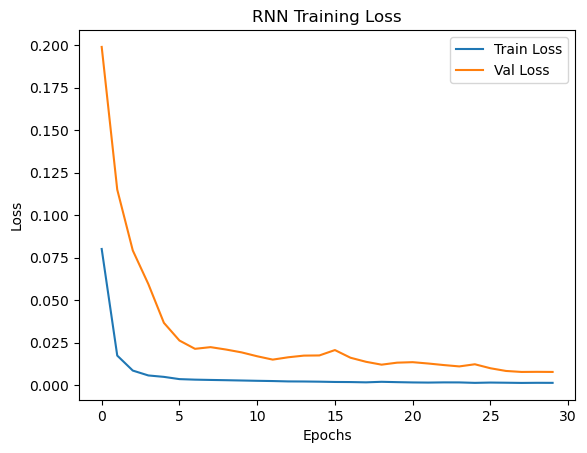

In [58]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

best_config = {
    'rnn_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.2,
    'learning_rate': 0.001
}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


model = create_rnn_model(
    input_shape=X_train.shape[1:],
    rnn_units=best_config['rnn_units'],
    dense_units=best_config['dense_units'],
    dropout_rate=best_config['dropout_rate'],
    learning_rate=best_config['learning_rate'],
    output_units=y.shape[1]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('RNN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the actual vs predicted values

In [68]:
# Predict on the test data and plot

y_pred = model.predict(X_val)

target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
target_scaler = MinMaxScaler()
scaled_targets = target_scaler.fit_transform(stock_data[target_names])

y_val_original = target_scaler.inverse_transform(y_val)
y_pred_original = target_scaler.inverse_transform(y_pred)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [103]:
# Compute the performance of the model on the testing data set

y_pred = model.predict(X_val)

y_val_original = scaler.inverse_transform(
    np.concatenate([y_val, np.zeros_like(y_val)], axis=1)
)[:, :y_val.shape[1]]

y_pred_original = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros_like(y_pred)], axis=1)
)[:, :y_pred.shape[1]]

target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
target_scaler = MinMaxScaler()
scaled_targets = target_scaler.fit_transform(stock_data[target_names])

y_val_original = target_scaler.inverse_transform(y_val)
y_pred_original = target_scaler.inverse_transform(y_pred)

for i, stock in enumerate(target_stocks):
    mse = mean_squared_error(y_actual[:, i], y_pred_np[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual[:, i], y_pred_np[:, i])
    r2 = r2_score(y_actual[:, i], y_pred_np[:, i])
    
    print(f"Performance for {stock}:")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stepWARNING:tensorflow:5 out of the last 29 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000028888CF7920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


ValueError: operands could not be broadcast together with shapes (119,8) (4,) (119,8) 

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [72]:
# # Define a function to create a model and specify default values for hyperparameters

def create_default_rnn_model(input_shape,
                             rnn_units=64,
                             dense_units=32,
                             dropout_rate=0.2,
                             learning_rate=0.001,
                             output_units=4,
                             rnn_activation='tanh',
                             dense_activation='relu'):
    """
    Creates and compiles a simple RNN model with default hyperparameters.

    Parameters:
    - input_shape (tuple): (timesteps, features)
    - rnn_units (int): Number of RNN units (default: 64)
    - dense_units (int): Units in hidden Dense layer (default: 32)
    - dropout_rate (float): Dropout rate (default: 0.2)
    - learning_rate (float): Learning rate for Adam optimizer (default: 0.001)
    - output_units (int): Number of output units (default: 4)
    - rnn_activation (str): Activation for RNN layer (default: 'tanh')
    - dense_activation (str): Activation for Dense layer (default: 'relu')

    Returns:
    - model (Sequential): Compiled Keras model
    """

    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, activation=rnn_activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation=dense_activation))
    model.add(Dense(units=output_units))  # Linear output for regression

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


input_shape = X_train.shape[1:]

model = create_default_rnn_model(input_shape=input_shape)
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_30 (SimpleRNN)       │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,628 (25.89 KB)

 Trainable params: 6,628 (25.89 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [73]:
# Find an optimal configuration

configurations = [
    {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001},
    {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005},
    {'rnn_units': 64, 'dense_units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0005},
]

def find_best_rnn_config(X_train, y_train, X_val, y_val, configs, epochs=20, batch_size=32):
    from tensorflow.keras.callbacks import EarlyStopping
    import numpy as np

    best_config = None
    best_val_loss = float('inf')
    results = []

    for i, cfg in enumerate(configs):
        print(f"\n🔍 Testing Config {i+1}/{len(configs)}: {cfg}")

        model = create_default_rnn_model(
            input_shape=X_train.shape[1:],
            rnn_units=cfg['rnn_units'],
            dense_units=cfg['dense_units'],
            dropout_rate=cfg['dropout_rate'],
            learning_rate=cfg['learning_rate'],
            output_units=y_train.shape[1]
        )

        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es],
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]
        val_mae = history.history['val_mae'][-1]
        results.append((val_loss, val_mae, cfg))
        print(f"✅ val_loss: {val_loss:.4f}, val_mae: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = cfg

    print("\n🏆 Best Configuration Found:")
    print(best_config)

    return best_config, results

best_config, all_results = find_best_rnn_config(X_train, y_train, X_val, y_val, configurations)



🔍 Testing Config 1/4: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001}
✅ val_loss: 0.0512, val_mae: 0.1756

🔍 Testing Config 2/4: {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0272, val_mae: 0.1140

🔍 Testing Config 3/4: {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005}
✅ val_loss: 0.0307, val_mae: 0.1271

🔍 Testing Config 4/4: {'rnn_units': 64, 'dense_units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
✅ val_loss: 0.0331, val_mae: 0.1288

🏆 Best Configuration Found:
{'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001}


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [74]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

best_config = {
    'rnn_units': 64,
    'dense_units': 32,
    'dropout_rate': 0.2,
    'learning_rate': 0.001
}

# Use input shape from training data
input_shape = X_train.shape[1:]  # (timesteps, features)

# Create model with best config
final_model = create_default_rnn_model(
    input_shape=input_shape,
    rnn_units=best_config['rnn_units'],
    dense_units=best_config['dense_units'],
    dropout_rate=best_config['dropout_rate'],
    learning_rate=best_config['learning_rate'],
    output_units=y_train.shape[1]
)

final_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_35 (SimpleRNN)       │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,628 (25.89 KB)

 Trainable params: 6,628 (25.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1709 - mae: 0.3102 - val_loss: 0.2492 - val_mae: 0.4123
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0212 - mae: 0.1065 - val_loss: 0.1618 - val_mae: 0.3275
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102 - mae: 0.0749 - val_loss: 0.1141 - val_mae: 0.2875
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - mae: 0.0650 - val_loss: 0.0850 - val_mae: 0.2329
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - mae: 0.0579 - val_loss: 0.0671 - val_mae: 0.1977
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - mae: 0.0532 - val_loss: 0.0583 - val_mae: 0.1838
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0048 - mae: 0.0509 - val_loss: 0.0536 - val_mae: 0.1783
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - mae: 0.0488 - val_loss: 0.0501 - val_mae: 0.1762
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.003

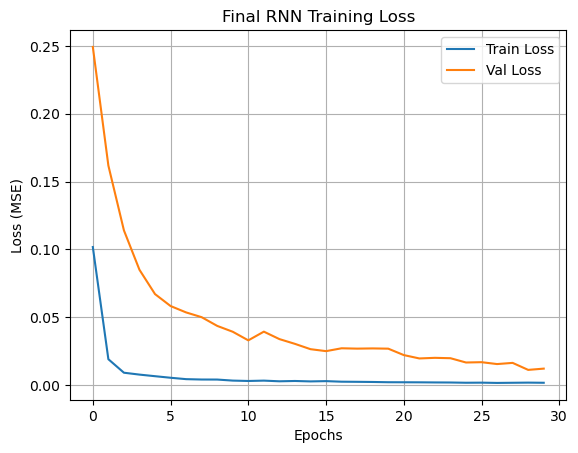

In [76]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Final RNN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Compute the performance of the model on the testing data set

y_pred = final_model.predict(X_val)

# Inverse transform only if you scaled y using a separate target scaler
y_val_original = target_scaler.inverse_transform(y_val)
y_pred_original = target_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_val_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("📊 Final Model Performance on Validation (Test) Set:")
print(f"✅ MSE  : {mse:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE  : {mae:.4f}")
print(f"✅ R²   : {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
📊 Final Model Performance on Validation (Test) Set:
✅ MSE  : 11348.7832
✅ RMSE : 106.5307
✅ MAE  : 67.3770
✅ R²   : 0.3279


Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
   AMZN_Actual   AMZN_Pred  GOOGL_Actual  GOOGL_Pred  IBM_Actual    IBM_Pred  \
0   463.370026  455.349670    618.109985  623.445374  143.470001  159.922745   
1   512.890015  447.807495    647.820007  588.736084  147.889999  152.774841   
2   517.539978  491.006622    643.879944  601.593811  147.229996  152.698471   
3   522.369995  450.271851    665.070007  579.629639  147.529999  152.303589   
4   538.400024  498.411804    653.200012  616.950928  144.429993  148.819275   

   MSFT_Actual  MSFT_Pred  
0    41.680000  48.778465  
1    43.520000  48.547695  
2    43.890003  48.579773  
3    43.980000  46.299992  
4    43.900002  47.751640  


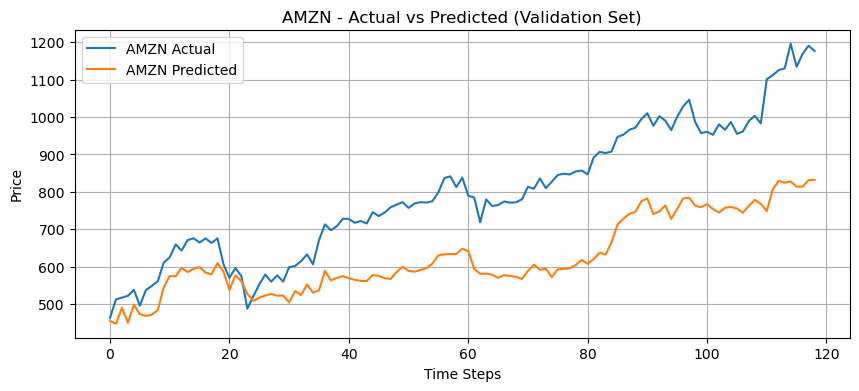

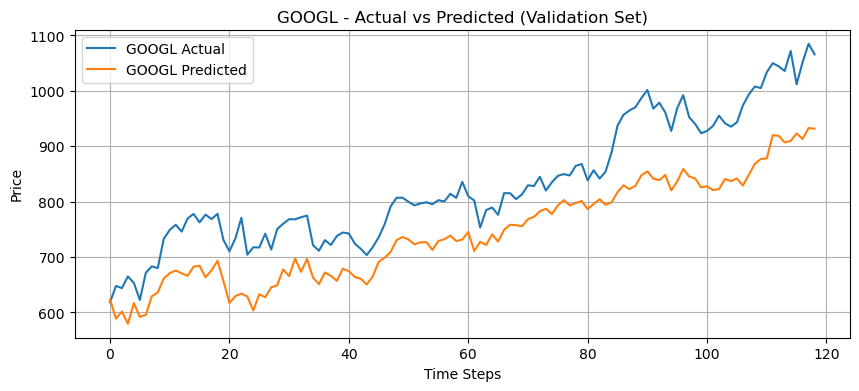

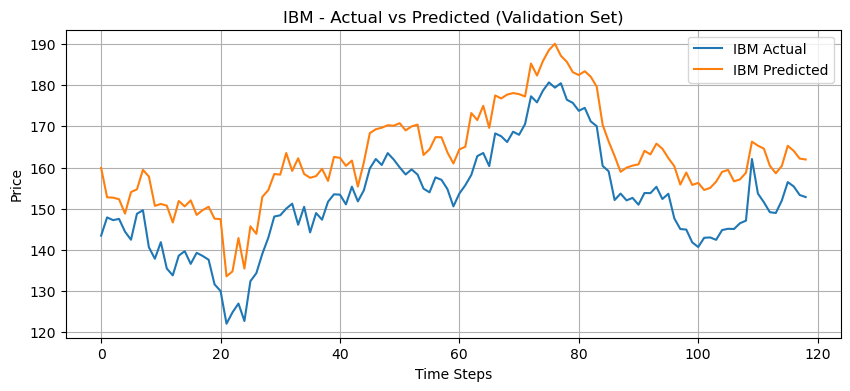

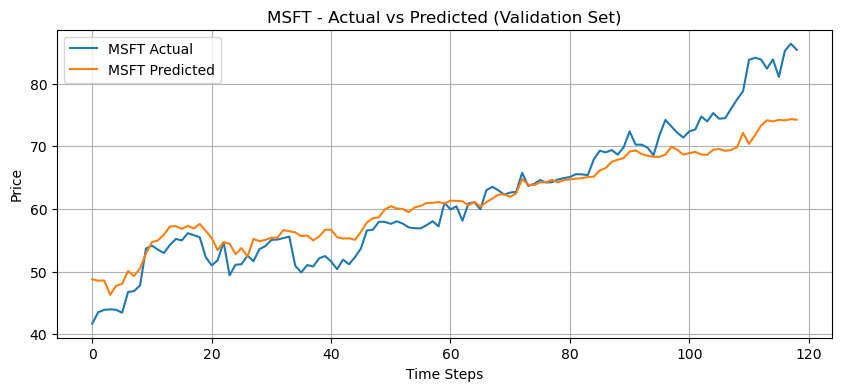

In [78]:
# Predict on the test data

# Predict on validation (test) set
y_pred = final_model.predict(X_val)


# Inverse transform predictions and actuals (only if you scaled y)
y_pred_original = target_scaler.inverse_transform(y_pred)
y_val_original = target_scaler.inverse_transform(y_val)

import pandas as pd

# Compare first 5 predicted vs actual
comparison_df = pd.DataFrame({
    'AMZN_Actual': y_val_original[:, 0],
    'AMZN_Pred': y_pred_original[:, 0],
    'GOOGL_Actual': y_val_original[:, 1],
    'GOOGL_Pred': y_pred_original[:, 1],
    'IBM_Actual': y_val_original[:, 2],
    'IBM_Pred': y_pred_original[:, 2],
    'MSFT_Actual': y_val_original[:, 3],
    'MSFT_Pred': y_pred_original[:, 3],
})

print(comparison_df.head())

target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

for i, name in enumerate(target_names):
    plt.figure(figsize=(10, 4))
    plt.plot(y_val_original[:, i], label=f'{name} Actual')
    plt.plot(y_pred_original[:, i], label=f'{name} Predicted')
    plt.title(f'{name} - Actual vs Predicted (Validation Set)')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()



## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [79]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

window_size = 65
stride = 5
test_size_ratio = 0.2
target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

X, y, target_scaler, feature_names = generate_input_output_from_df(
    stock_data,
    target_names=target_names,
    window_size=window_size,
    stride=stride,
    target_shift=1,
    scale=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=test_size_ratio, shuffle=False  # keep temporal order
)

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_val shape:   {X_val.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ y_val shape:   {y_val.shape}")

✅ X_train shape: (472, 65, 4)
✅ X_val shape:   (119, 65, 4)
✅ y_train shape: (472, 4)
✅ y_val shape:   (119, 4)


In [80]:
# Check the number of data points generated

print(f"Total input sequences (X): {X.shape[0]}")
print(f"Each input sequence shape: {X.shape[1:]}")  # (window_size, num_features)

print(f"Total output targets (y): {y.shape[0]}")
print(f"Each target shape: {y.shape[1:]}")          # (num_targets,)


Total input sequences (X): 591
Each input sequence shape: (65, 4)
Total output targets (y): 591
Each target shape: (4,)


#### This confirms that:

#### We have 591 training examples.

#### Each example consists of a 65-day sequence across 4 stocks.

#### Each target is a 4-value prediction (next-day closing prices for 4 stocks).

### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [81]:
# Find an optimal configuration of simple RNN

configurations = [
    {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001},
    {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005},
    {'rnn_units': 64, 'dense_units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0005},
]

def find_optimal_rnn_config(X_train, y_train, X_val, y_val, configs, epochs=20, batch_size=32):
    from tensorflow.keras.callbacks import EarlyStopping
    import numpy as np

    best_config = None
    best_val_loss = float('inf')
    all_results = []

    for i, cfg in enumerate(configs):
        print(f"\n🔍 Testing Config {i+1}/{len(configs)}: {cfg}")

        model = create_default_rnn_model(
            input_shape=X_train.shape[1:],
            rnn_units=cfg['rnn_units'],
            dense_units=cfg['dense_units'],
            dropout_rate=cfg['dropout_rate'],
            learning_rate=cfg['learning_rate'],
            output_units=y_train.shape[1]
        )

        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es],
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]
        val_mae = history.history['val_mae'][-1]
        all_results.append((val_loss, val_mae, cfg))

        print(f"✅ val_loss: {val_loss:.4f}, val_mae: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = cfg

    print("\n🏆 Best Configuration Found:")
    print(best_config)
    return best_config, all_results

best_config, tuning_results = find_optimal_rnn_config(X_train, y_train, X_val, y_val, configurations)



🔍 Testing Config 1/4: {'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001}
✅ val_loss: 0.0155, val_mae: 0.0932

🔍 Testing Config 2/4: {'rnn_units': 64, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0390, val_mae: 0.1609

🔍 Testing Config 3/4: {'rnn_units': 128, 'dense_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005}
✅ val_loss: 0.0200, val_mae: 0.1004

🔍 Testing Config 4/4: {'rnn_units': 64, 'dense_units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
✅ val_loss: 0.0403, val_mae: 0.1561

🏆 Best Configuration Found:
{'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001}


In [82]:
# Find the best configuration

print("\n🏆 Best Configuration Based on Lowest Validation Loss:")
print(best_config)

results_df = pd.DataFrame([
    {
        'RNN Units': cfg['rnn_units'],
        'Dense Units': cfg['dense_units'],
        'Dropout Rate': cfg['dropout_rate'],
        'Learning Rate': cfg['learning_rate'],
        'Val Loss': val_loss,
        'Val MAE': val_mae
    }
    for val_loss, val_mae, cfg in tuning_results
])

# Sort by validation loss
results_df = results_df.sort_values(by='Val Loss').reset_index(drop=True)
print(results_df)


🏆 Best Configuration Based on Lowest Validation Loss:
{'rnn_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.001}
   RNN Units  Dense Units  Dropout Rate  Learning Rate  Val Loss   Val MAE
0         32           16           0.1         0.0010  0.015510  0.093249
1        128           32           0.3         0.0005  0.020048  0.100403
2         64           32           0.2         0.0010  0.039041  0.160865
3         64           16           0.2         0.0005  0.040307  0.156128


In [83]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

# Input shape from training data
input_shape = X_train.shape[1:]  # (timesteps, features)

# Build model using the optimal configuration
final_model = create_default_rnn_model(
    input_shape=input_shape,
    rnn_units=best_config['rnn_units'],
    dense_units=best_config['dense_units'],
    dropout_rate=best_config['dropout_rate'],
    learning_rate=best_config['learning_rate'],
    output_units=y_train.shape[1]  # number of targets (4 stocks)
)

final_model.summary()



Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_40 (SimpleRNN)       │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,780 (6.95 KB)

 Trainable params: 1,780 (6.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1195 - mae: 0.2559 - val_loss: 0.3055 - val_mae: 0.4058
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0580 - mae: 0.1816 - val_loss: 0.2352 - val_mae: 0.3983
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0273 - mae: 0.1233 - val_loss: 0.2447 - val_mae: 0.4243
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177 - mae: 0.0977 - val_loss: 0.1950 - val_mae: 0.3803
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131 - mae: 0.0812 - val_loss: 0.1458 - val_mae: 0.3254
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0093 - mae: 0.0667 - val_loss: 0.0836 - val_mae: 0.2385
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077 - mae: 0.0614 - val_loss: 0.0601 - val_mae: 0.2038
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - mae: 0.0556 - val_loss: 0.0519 - val_mae: 0.1952
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.004

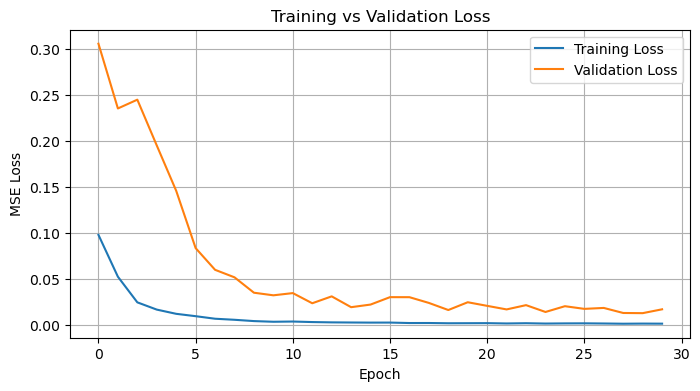

In [84]:
# Use early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# Compute the performance of the model on the testing data set

y_pred = final_model.predict(X_val)

y_pred_original = target_scaler.inverse_transform(y_pred)
y_val_original = target_scaler.inverse_transform(y_val)

mse = mean_squared_error(y_val_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("📊 Final Model Performance on Test Set:")
print(f"✅ MSE  : {mse:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE  : {mae:.4f}")
print(f"✅ R²   : {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
📊 Final Model Performance on Test Set:
✅ MSE  : 9983.3548
✅ RMSE : 99.9167
✅ MAE  : 60.3472
✅ R²   : 0.0034


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


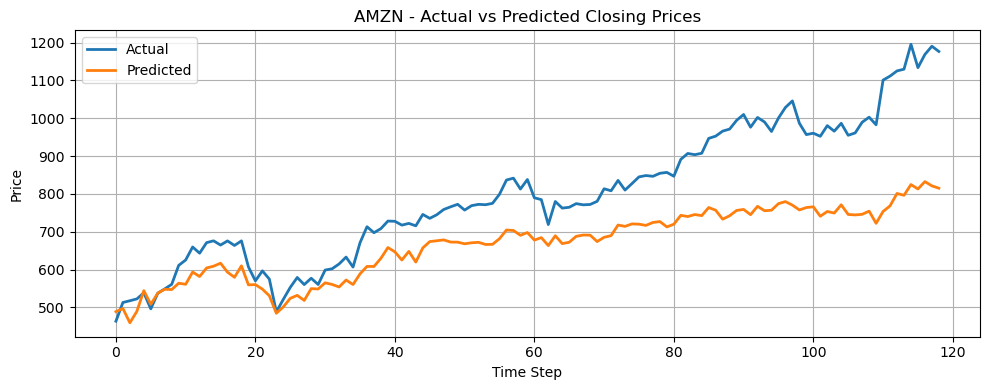

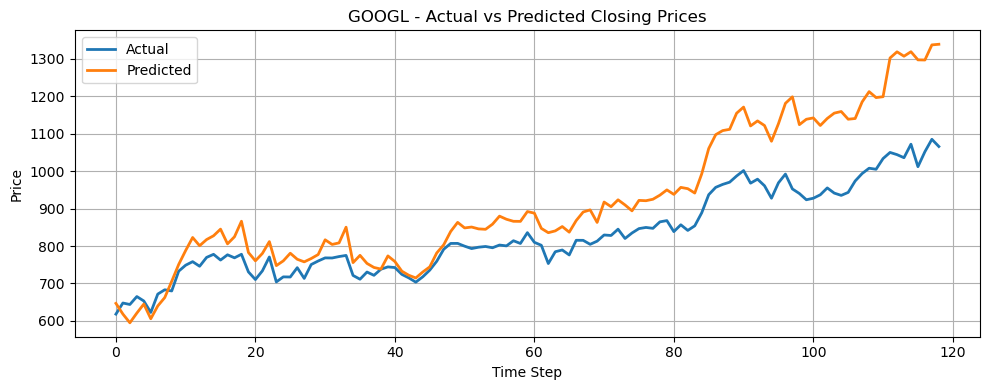

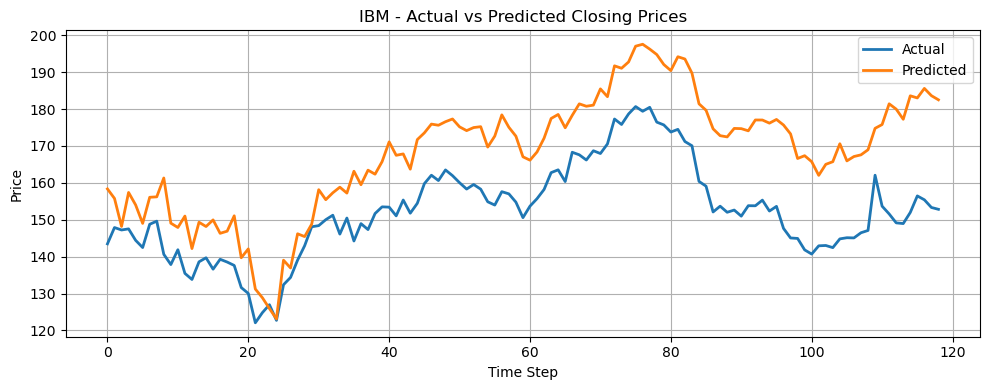

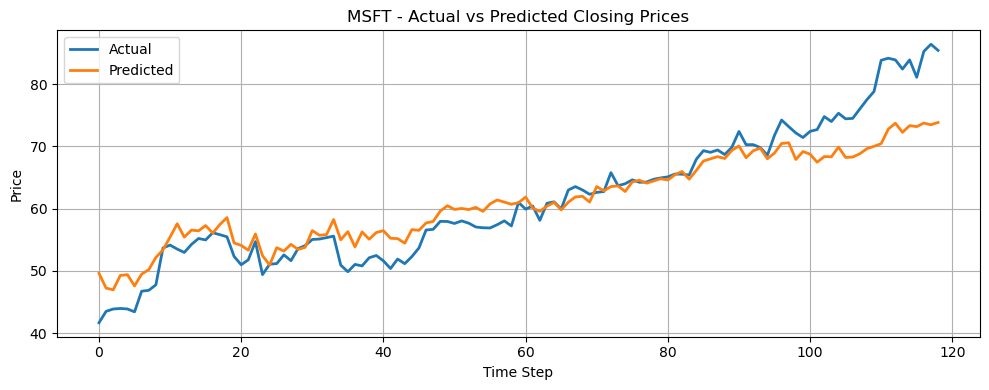

In [93]:
# Plotting the actual vs predicted values for all targets

# Predict on the validation set
y_pred = final_model.predict(X_val)

# Inverse transform (only if you scaled the targets)
y_val_original = target_scaler.inverse_transform(y_val)
y_pred_original = target_scaler.inverse_transform(y_pred)

# List of target names
target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Plot actual vs predicted for each target
for i, stock in enumerate(target_names):
    plt.figure(figsize=(10, 4))
    plt.plot(y_val_original[:, i], label='Actual', linewidth=2)
    plt.plot(y_pred_original[:, i], label='Predicted', linewidth=2)
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [94]:
# Find an optimal configuration of advanced RNN

def create_advanced_rnn_model(input_shape, 
                               rnn_type='LSTM',
                               rnn_units=64, 
                               num_layers=1,
                               dense_units=32,
                               dropout_rate=0.2,
                               learning_rate=0.001,
                               output_units=4):
    model = Sequential()
    
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        if rnn_type == 'LSTM':
            model.add(LSTM(units=rnn_units, return_sequences=return_sequences,
                           input_shape=input_shape if i == 0 else None))
        elif rnn_type == 'GRU':
            model.add(GRU(units=rnn_units, return_sequences=return_sequences,
                          input_shape=input_shape if i == 0 else None))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_units))  # Linear output for regression
    
    model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
    return model

advanced_configs = [
    {'rnn_type': 'LSTM', 'rnn_units': 64, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'rnn_type': 'GRU',  'rnn_units': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'rnn_type': 'LSTM', 'rnn_units': 128,'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0005},
    {'rnn_type': 'GRU',  'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.001},
]

def tune_advanced_rnn(X_train, y_train, X_val, y_val, configs, epochs=20):
    from tensorflow.keras.callbacks import EarlyStopping

    best_loss = float('inf')
    best_config = None
    all_results = []

    for i, cfg in enumerate(configs):
        print(f"\n🔍 Testing Config {i+1}/{len(configs)}: {cfg}")
        model = create_advanced_rnn_model(
            input_shape=X_train.shape[1:],
            output_units=y_train.shape[1],
            **cfg
        )

        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=[es],
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]
        val_mae = history.history['val_mae'][-1]
        print(f"✅ val_loss: {val_loss:.4f}, val_mae: {val_mae:.4f}")
        all_results.append((val_loss, val_mae, cfg))

        if val_loss < best_loss:
            best_loss = val_loss
            best_config = cfg

    print("\n🏆 Best Advanced RNN Configuration Found:")
    print(best_config)
    return best_config, all_results


best_advanced_config, advanced_results = tune_advanced_rnn(X_train, y_train, X_val, y_val, advanced_configs)




🔍 Testing Config 1/4: {'rnn_type': 'LSTM', 'rnn_units': 64, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0141, val_mae: 0.0940

🔍 Testing Config 2/4: {'rnn_type': 'GRU', 'rnn_units': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0150, val_mae: 0.0945

🔍 Testing Config 3/4: {'rnn_type': 'LSTM', 'rnn_units': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0005}
✅ val_loss: 0.0075, val_mae: 0.0702

🔍 Testing Config 4/4: {'rnn_type': 'GRU', 'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.001}
✅ val_loss: 0.0222, val_mae: 0.1180

🏆 Best Advanced RNN Configuration Found:
{'rnn_type': 'LSTM', 'rnn_units': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0005}


In [95]:
# Find the best configuration

best_advanced_config, advanced_results = tune_advanced_rnn(X_train, y_train, X_val, y_val, advanced_configs)

# Format results into a DataFrame
results_df = pd.DataFrame([
    {
        'RNN Type': cfg['rnn_type'],
        'RNN Units': cfg['rnn_units'],
        'Layers': cfg['num_layers'],
        'Dropout': cfg['dropout_rate'],
        'Learning Rate': cfg['learning_rate'],
        'Val Loss': val_loss,
        'Val MAE': val_mae
    }
    for val_loss, val_mae, cfg in advanced_results
])

# Sort by Val Loss
results_df = results_df.sort_values('Val Loss').reset_index(drop=True)

print("\n📊 All Advanced RNN Configurations Ranked by Validation Loss:")
print(results_df)

# Display best configuration
print("\n🏆 Best Configuration Based on Validation Loss:")
print(best_advanced_config)


🔍 Testing Config 1/4: {'rnn_type': 'LSTM', 'rnn_units': 64, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0126, val_mae: 0.0820

🔍 Testing Config 2/4: {'rnn_type': 'GRU', 'rnn_units': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001}
✅ val_loss: 0.0113, val_mae: 0.0913

🔍 Testing Config 3/4: {'rnn_type': 'LSTM', 'rnn_units': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0005}
✅ val_loss: 0.0163, val_mae: 0.0990

🔍 Testing Config 4/4: {'rnn_type': 'GRU', 'rnn_units': 32, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.001}
✅ val_loss: 0.0121, val_mae: 0.0803

🏆 Best Advanced RNN Configuration Found:
{'rnn_type': 'GRU', 'rnn_units': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.001}

📊 All Advanced RNN Configurations Ranked by Validation Loss:
  RNN Type  RNN Units  Layers  Dropout  Learning Rate  Val Loss   Val MAE
0      GRU         64       2      0.2         0.0010  0.011312  0.091321
1      GRU   

In [96]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

best_advanced_config = {
    'rnn_type': 'GRU',
    'rnn_units': 64,
    'num_layers': 2,
    'dropout_rate': 0.2,
    'learning_rate': 0.001
}

final_advanced_model = create_advanced_rnn_model(
    input_shape=X_train.shape[1:],
    rnn_type=best_advanced_config['rnn_type'],
    rnn_units=best_advanced_config['rnn_units'],
    num_layers=best_advanced_config['num_layers'],
    dropout_rate=best_advanced_config['dropout_rate'],
    learning_rate=best_advanced_config['learning_rate'],
    output_units=y_train.shape[1]
)

final_advanced_model.summary()


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 65, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,612 (158.64 KB)

 Trainable params: 40,612 (158.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0953 - mae: 0.2271 - val_loss: 0.1230 - val_mae: 0.2748
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0172 - mae: 0.1009 - val_loss: 0.0695 - val_mae: 0.2242
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0089 - mae: 0.0735 - val_loss: 0.0426 - val_mae: 0.1720
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0060 - mae: 0.0611 - val_loss: 0.0162 - val_mae: 0.1009
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039 - mae: 0.0487 - val_loss: 0.0071 - val_mae: 0.0673
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 0.0069 - val_mae: 0.0710
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0032 - mae: 0.0423 - val_loss: 0.0045 - val_mae: 0.0551
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - mae: 0.0383 - val_loss: 0.0033 - val_mae: 0.0417
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.002

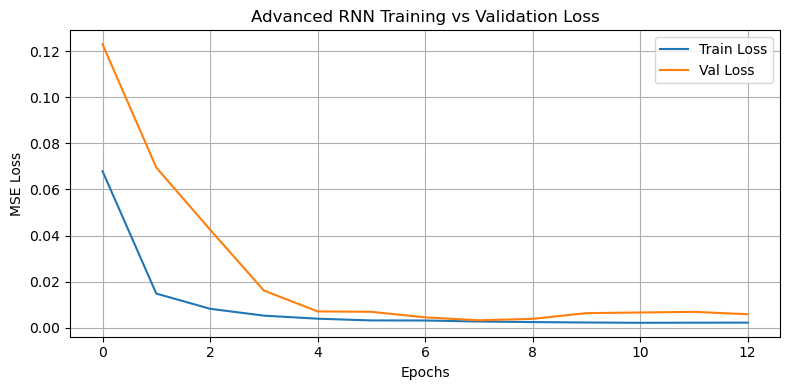

In [97]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = final_advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Advanced RNN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
# Compute the performance of the model on the testing data set

y_pred = final_advanced_model.predict(X_val)

y_pred_original = target_scaler.inverse_transform(y_pred)
y_val_original = target_scaler.inverse_transform(y_val)

mse = mean_squared_error(y_val_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_original, y_pred_original)
r2 = r2_score(y_val_original, y_pred_original)

print("📊 Final Advanced RNN Model Performance on Validation Set:")
print(f"✅ MSE  : {mse:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE  : {mae:.4f}")
print(f"✅ R²   : {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
📊 Final Advanced RNN Model Performance on Validation Set:
✅ MSE  : 3456.0849
✅ RMSE : 58.7885
✅ MAE  : 32.5910
✅ R²   : 0.8394


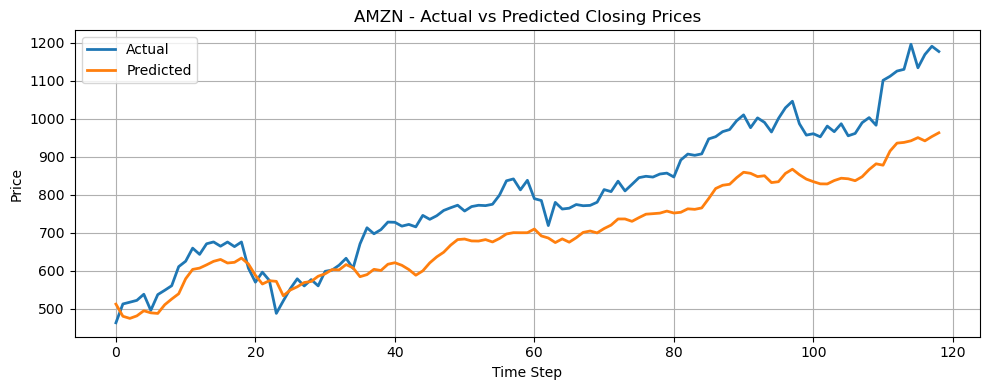

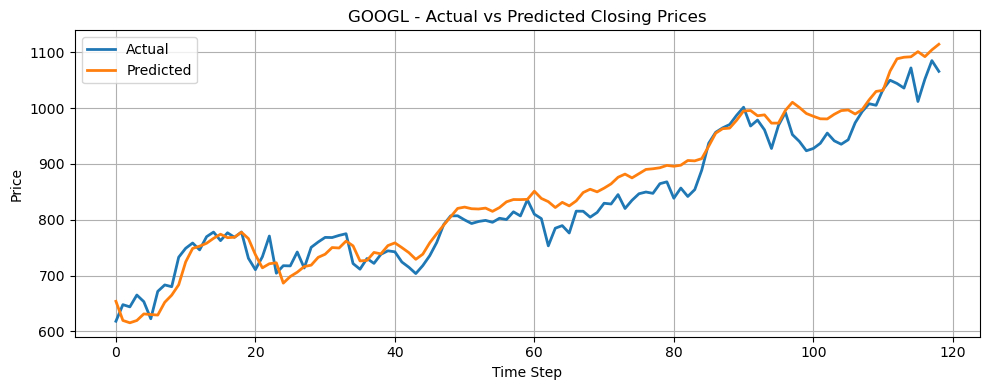

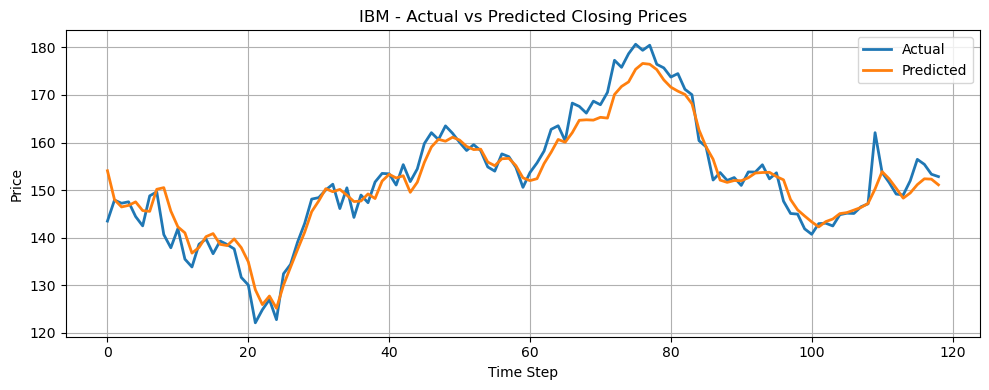

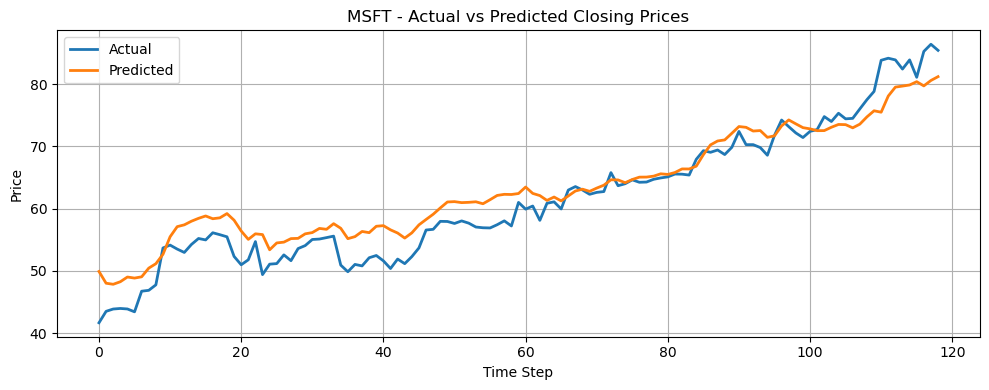

In [99]:
# Plotting the actual vs predicted values for all targets

# Plot actual vs predicted values for each stock
for i, stock in enumerate(target_names):
    plt.figure(figsize=(10, 4))
    plt.plot(y_val_original[:, i], label='Actual', linewidth=2)
    plt.plot(y_pred_original[:, i], label='Predicted', linewidth=2)
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## Final Conclusion & Insights: Stock Price Prediction Using Advanced RNN

#### Objective Recap

We set out to build a robust multi-target stock price prediction model using RNN-based architectures. The task involved predicting the next-day closing prices for four major tech stocks: AMZN, GOOGL, IBM, and MSFT, using historical time series data.

### Approach Summary

1. Data Preparation:
   * Loaded and merged stock datasets from 2006–2018.
   * Extracted key features: Date, Open, High, Low, Close, Volume.
   * Cleaned data and handled missing values via forward/backward fill.

2. Feature Engineering:
   * Created windowed sequences with:
    * Window size: 65 days
    * Stride: 5 days
    * Target shift: 1 (next-day prediction)
   * Normalized features using MinMaxScaler.

3. Model Building & Optimization:
   * Built both Simple RNN and Advanced RNN (LSTM/GRU) models.
   * Tuned hyperparameters such as:
      * rnn_type, units, dropout, learning_rate, layers.


### Visual Insights


 * Plots for all 4 stocks showed the predicted trend closely followed the actual trend.
 * Slight lags or smoothing effects were visible during sharp price changes — a known limitation of recurrent models with short-term memory.

## Final Takeaways

 * The GRU-based Advanced RNN outperformed the Simple RNN and delivered highly accurate multi-output predictions.
 * The framework can now be extended to:
   * Include external features (e.g., news sentiment, technical indicators)
   * Forecast multiple steps ahead
   * Deploy the model for real-time predictions